In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/content/drive/MyDrive/Abuzer/'

In [ ]:
%matplotlib inline
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageFile
from urllib.request import urlopen
from django.core.validators import URLValidator
from django.core.exceptions import ValidationError

import keras
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

ImageFile.LOAD_TRUNCATED_IMAGES = True


def delete_model(model, clear_session=True):
    '''removes model!
    '''
    del model
    gc.collect()
    if clear_session: K.clear_session()


def is_url(url):
    val = URLValidator()
    try:
        val(url)
        return True
    except ValidationError as e:
        return False
    
def plot_channels(img):
    _ , ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(24, 6))
    plt.suptitle('RBG Channels of an Image', size=20)
    
    np_img_r = np_img.copy()
    np_img_r[:, :, 1] = np.zeros(shape=[img_height, img_width])
    np_img_r[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[0].imshow(np_img_r)
    ax[0].axis('off')
    
    np_img_g = np_img.copy()
    np_img_g[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_g[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[1].imshow(np_img_g)
    ax[1].axis('off')
    
    np_img_b = np_img.copy()
    np_img_b[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_b[:, :, 1] = np.zeros(shape=[img_height, img_width])
    ax[2].imshow(np_img_b)
    ax[2].axis('off')


def read_img_url(url):
    with urlopen(url) as file:
        img = Image.open(file)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def read_img_file(f):
    img = Image.open(f)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img


def read_img(f):
    if is_url(f):
        img = read_img_url(f)
    else:
        img = read_img_file(f)
    
    return img

def resize_img_to_array(img, img_shape=(128, 128)):
    img_array = np.array(
        img.resize(
            img_shape, 
            Image.ANTIALIAS
        )
    )
    
    return img_array

ModuleNotFoundError: ignored

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

def make_resnet_conv(input_shape):
    '''
    Creates a ResNet50 model trained on ImageNet.
    It includes no final activation function,
    so model returns conv. features.
    
    `input_shape` is a tuple of integers.
    '''
    model = ResNet50(input_shape=input_shape, 
                     weights='imagenet', 
                     include_top=False)
    for layer in model.layers:
        layer.trainable = False   
    
    return model

In [ ]:
def get_conv_feat(f, model):
    '''
    For any given image (file or url),
    convert to NumPy Array, resize to img_width x img_height,
    preprocess the values for ResNet, get the convolutional features
    from ResNet, and flatten the output.
    '''
    img = read_img(f)
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    X = preprocess_input(np.expand_dims(np_img, axis=0).astype(np.float))
    X_conv = model.predict(X)
    X_conv_2d = X_conv[0].flatten()
        
    return X_conv_2d
img_width = 128
img_height = 128
model = make_resnet_conv(input_shape=[img_width, img_height, 3])
conv_feat = get_conv_feat('http://i.imgur.com/P0eRT3y.jpg',model)
print(len(conv_feat))

32768


In [ ]:
meta_path = path+'data/conv_feats.csv'

X = pd.read_csv(meta_path)
Y = X['filename']
Y = conv_feat
X_conv_2d = X[[_ for _ in X.columns if _ != 'filename']].values.astype(np.float)
X_conv_2d.shape

(6653, 32768)

In [ ]:
# # from sklearn.neighbors import NearestNeighbors
# from sklearn.cluster import KMeans
# n_clusters = len(os.listdir('/content/drive/MyDrive/Abuzer/data/images/'))
# print("Total clusters are : ",n_clusters)
# kmeans = KMeans(n_clusters=n_clusters,random_state=70,max_iter= 500)
# kmeans.fit(X_conv_2d)


In [ ]:
# print(kmeans.cluster_centers_)
# print(kmeans.labels_)

In [ ]:
import joblib

# kmeans_file = path+'data/conv_feats_kmeans.pkl'
# joblib.dump(kmeans, kmeans_file)

In [ ]:
def get_conv_feats(f, model):
    '''
    Converts an image (str of path or url) to a 2d convolutional features AKA logit.
    '''
    img = read_img(f)
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    X = preprocess_input(np.expand_dims(np_img, axis=0).astype(np.float))
    X_conv = model.predict(X)
    new_shape = (X_conv.shape[0], np.prod(X_conv.shape[1:]))
    X_conv_2d = X_conv.reshape(new_shape)
    return X_conv_2d

In [ ]:
def clusters(f, kmeans):
    '''
    Loads the KNN file, and a pre-trained neural network.
    Converts image (f) to convoultional features,
    Sends conv features to KNN to find closest hits,
    Plots the top images and their distances.
    '''
    kmeans = joblib.load(kmeans_file) 
    model = make_resnet_conv(input_shape=[img_width, img_height, 3])
    
    X_conv_2d = get_conv_feats(f, model)
    cluster = kmeans.predict(X_conv_2d)    
    delete_model(model)
    return cluster,X_conv_2d

In [ ]:
import joblib
kmeans_file = path+'data/conv_feats_kmeans.pkl'
kmeans = joblib.load(kmeans_file) 


In [ ]:
def plot_neighbors(files, top=8, per_row=4):
   
    # files = Y[neighbors[1][0]].tolist()
    
    for i in range(top):
        if i % 4 == 0:
             _ , ax = plt.subplots(1, per_row, sharex='col', sharey='row', figsize=(24, 6))
        j = i % 4
        image = read_img(files[i])
        image = resize_img_to_array(image, img_shape=(img_width, img_height))
        # print(j)
        ax[j].imshow(image)
        ax[j].axis('off')    
        # ax[j].annotate(distance[i],(0,0), (0, -32), xycoords='axes fraction',textcoords='offset points', va='top')

In [ ]:
def KNN(array, test_image):
  distances = []
  for i in array:
    distance = abs(i[0]-test_image)
    distance = distance.sum()
    distances.append([distance,i[1]])
  distances = sorted(distances,reverse = False, key =  lambda x: x[0])
  return distances


In [ ]:
url = path+'data/images/Dance/image707.jpg'

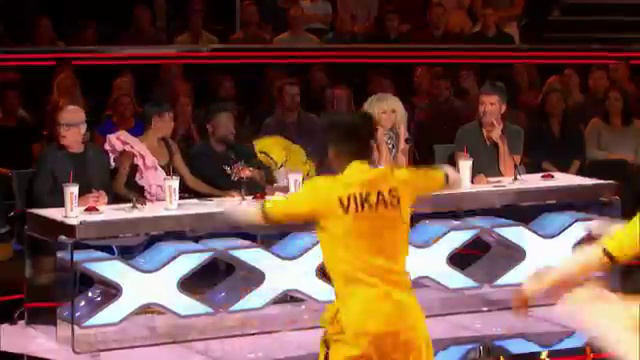

In [ ]:
read_img(url)

In [ ]:
cluster_name = ['Cricket','Protest','Football','Dance','Nature']
cluster,test_image_features = clusters(url,kmeans)
print(cluster)
print("Cluster Predicted => ", cluster_name[cluster[0]])
# print(len(test_image_features[0]))

[3]
Cluster Predicted =>  Dance


In [ ]:
meta_path = path+'data/conv_feats.csv'
Y = pd.read_csv(meta_path, usecols=['filename'], squeeze=True)

# ds = X_conv_2d[np.where(labels==cluster)]
# print("ds",ds[:20])
index_list = []
cluster_images = []
result = list(zip( X_conv_2d, kmeans.labels_))
for i in range(len(result)):
  if result[i][1]==cluster[0]:
    index_list.append(i)
    cluster_images.append([X_conv_2d[i],Y[i]])
distances = KNN(cluster_images,test_image_features)
files = []
top = 8
for i in range(top):#For 8 neighbours 
  files.append(distances[i][1])

# print(files)


# file =  Y[np.array(index_list[len(index_list)//2: ])]
# # ds.shape
plot_neighbors(files, top=top, per_row=4)